<a href="https://www.kaggle.com/code/pratikpal1/house-prices-prediction-competition?scriptVersionId=106495794" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
    
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pylab as plt 
import seaborn as sns

In [3]:
df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Quite a few null values can be seen

In [5]:
sns.set_theme(rc={'figure.figsize':(11,8)}, palette = 'plasma')

<AxesSubplot:>

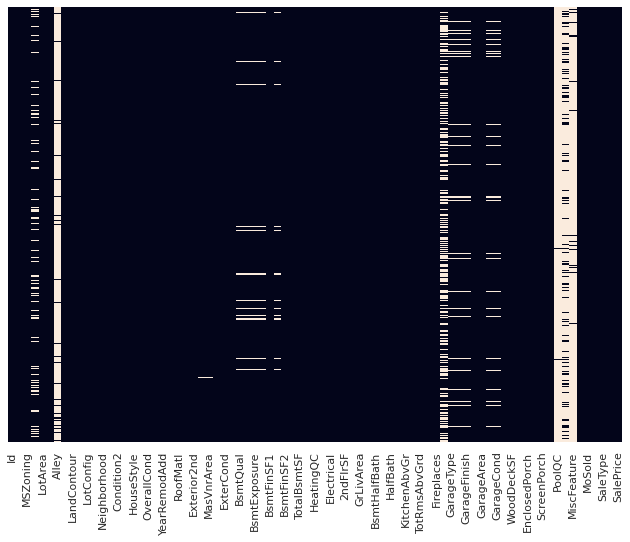

In [6]:
sns.heatmap(df.isnull(),yticklabels=False,cbar = False)

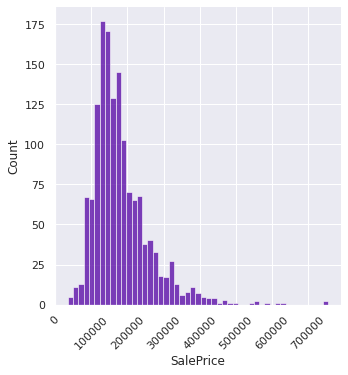

In [7]:
sns.displot(df, x = df.SalePrice)
plt.xticks(rotation=45);

In [8]:
df.SalePrice.median()

163000.0

In [9]:
df.SalePrice.median()/(df.SalePrice.max() - df.SalePrice.min())

0.22635745035411747

This should be our starting point for XGBRegressor : 0.22635

In [10]:
df.shape[0]

1460

UDF for Getting the features with objet type and filling them with Mode

In [11]:
def fill_mode(df_temp):
    data_object = df_temp.select_dtypes(include = "object").columns
    print(data_object)
    for i in data_object:
        df_temp[i] = df_temp[i].fillna(df_temp[i].mode()[0])
        print(f'filled data for {i} as {df_temp[i].mode()[0]}')
        
    return df_temp


UDF for Getting the features with int64 type and filling them with Mean

In [12]:
def fill_mean(df_temp):
    data_object = df_temp.select_dtypes(include = ["int64","float64"]).columns
    print(data_object)
    for i in data_object:
        df_temp[i] = df_temp[i].fillna(df_temp[i].mean())
        print(f'filled data for {i} as {df_temp[i].mean()}')
        
    return df_temp

## Feature Selection

We have 1460 records if we get more than 450 (30% of the data is 438) records as blank we would drop the feature.

In [13]:
drop_col = []
for i in df.columns:
    if (df[i].isnull().sum() > 450):
        drop_col.append(i)     
    else:
        continue

print(drop_col)

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [14]:
df.isnull().sum()[drop_col]

Alley          1369
FireplaceQu     690
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64

Only FireplaceQu feature can be salvaged as less than half the entries are blanks. Lets check if that has a correlation with price. We will try making predictions with all null values removed

In [15]:
drop_col.remove('FireplaceQu')

In [16]:
df[drop_col].isnull().sum()

Alley          1369
PoolQC         1453
Fence          1179
MiscFeature    1406
dtype: int64

In [17]:
df1 = df.drop(drop_col,axis =1)
df1.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


we drop the null values from 'FireplaceQu' to check its correlation and contribution to the SalePrice

In [18]:
df1.dropna().corrwith(df1['SalePrice']).sort_index()

1stFlrSF         0.560903
2ndFlrSF         0.270357
3SsnPorch        0.035029
BedroomAbvGr     0.085452
BsmtFinSF1       0.380394
BsmtFinSF2      -0.028909
BsmtFullBath     0.261448
BsmtHalfBath    -0.083110
BsmtUnfSF        0.136136
EnclosedPorch   -0.148789
Fireplaces       0.125135
FullBath         0.508674
GarageArea       0.632144
GarageCars       0.667489
GarageYrBlt      0.488018
GrLivArea        0.662289
HalfBath         0.192117
Id              -0.074858
KitchenAbvGr    -0.105757
LotArea          0.252301
LotFrontage      0.283097
LowQualFinSF     0.020532
MSSubClass      -0.101487
MasVnrArea       0.481089
MiscVal         -0.035237
MoSold           0.032827
OpenPorchSF      0.274933
OverallCond     -0.151409
OverallQual      0.776329
PoolArea         0.074615
SalePrice        1.000000
ScreenPorch      0.052342
TotRmsAbvGrd     0.547225
TotalBsmtSF      0.574926
WoodDeckSF       0.299824
YearBuilt        0.473073
YearRemodAdd     0.519747
YrSold           0.017793
dtype: float

In [19]:
df['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [20]:
df['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

I feel as there is no definate mode for this column we shall do dummy_na = True for this specific column or maybe try to do some feature engineering

In [21]:
df2 = df1.dropna()
print(df1.shape)
print(df2.shape)

(1460, 77)
(583, 77)


<AxesSubplot:>

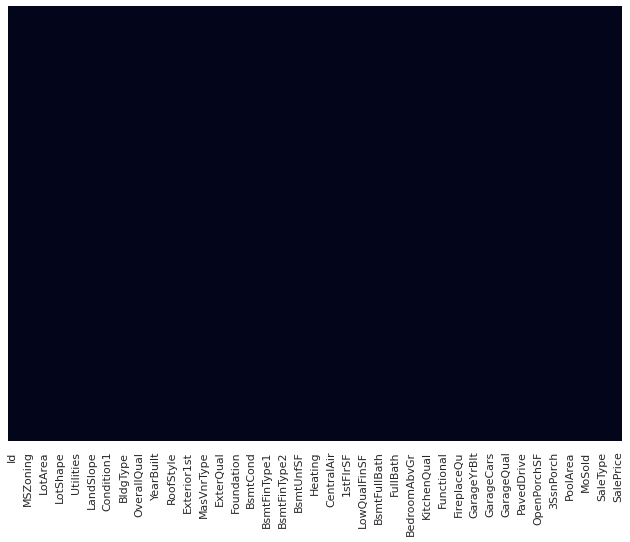

In [22]:
sns.heatmap(df2.isnull(),yticklabels = False,cbar = False)

<AxesSubplot:>

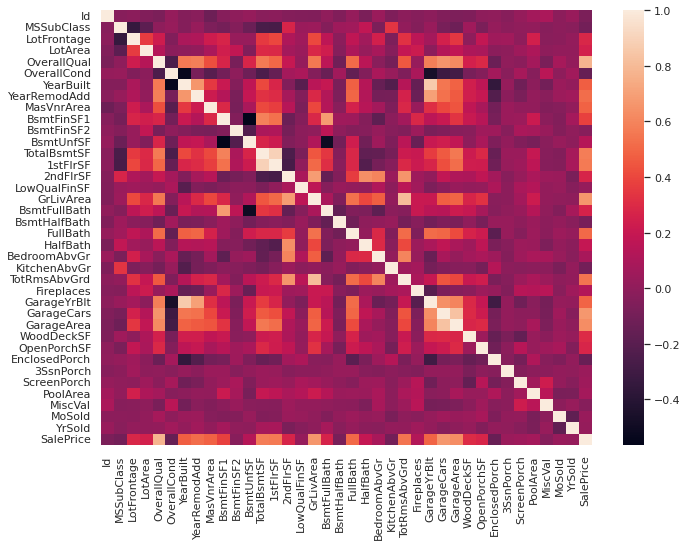

In [23]:
sns.heatmap(df2.corr())

We see quite a few cases with high multicolinearity. Now we will do priliminary analysis on df2. 
1. First we get the 1 hot encoding and check for multicolinearity
2. We will remove the features that contribute less to the output

In [24]:
df2 = pd.get_dummies(df2, drop_first = True)
df2.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_WD,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,1,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,0,0,1,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,0,0,1,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,0,0,1,0,0,1,0
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,0,0,0,0,0,1,0,0,1,0


There are now 210 features, this is a bit much. So we will check for features that have high corelation with each other

Removing the target columns for checking correlation, otherwise we will be removing useful features

In [25]:
df_corr = df2.drop('SalePrice', axis =1).corr()
#df_corr = df_corr.drop('SalePrice', axis =0)
df_corr.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       ...
       'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_New', 'SaleType_WD', 'SaleCondition_Alloca',
       'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=209)

In [26]:
high_correlation_features= set()
drop_list1=[]

We will put everything in a set first so that we don't have duplicates

In [27]:
i=0
for i in range(0,df_corr.shape[0]):
    for j in range(0,i):
        if df_corr.iat[i,j] > 0.75:
            high_correlation_features.add(df_corr.columns[j])

            
drop_list1 = list(high_correlation_features)
print(drop_list1)
print(len(drop_list1))
            

['YearBuilt', 'TotalBsmtSF', 'Exterior1st_CemntBd', 'SaleType_WD', 'Exterior1st_VinylSd', 'Neighborhood_NPkVill', 'Exterior1st_Plywood', 'MSZoning_FV', '2ndFlrSF', 'Exterior1st_Stucco', 'GrLivArea', 'SaleType_New', 'Exterior1st_Wd Sdng', 'Exterior1st_HdBoard', 'GarageCars', 'Exterior1st_MetalSd']
16


Now to remove the one of the columns that have high correlation from df2

In [28]:
df2.drop(drop_list1,axis =1,inplace =True)

Now we find the columns that individually contribute less than an arbitarty (lesser than 0.07) threshold to the SalePrice and drop them

In [29]:
drop_list_2 = []
corr_ser = df2.corrwith(df2['SalePrice']).abs().sort_values(ascending = True)
for i in df2.columns:
    if(corr_ser[i]< 0.07):
        drop_list_2.append(i)
        
print(drop_list_2)

['BsmtFinSF2', 'LowQualFinSF', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold', 'Street_Pave', 'LotShape_IR3', 'LandContour_Low', 'LandContour_Lvl', 'LotConfig_FR2', 'LotConfig_FR3', 'LandSlope_Mod', 'LandSlope_Sev', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Gilbert', 'Neighborhood_Mitchel', 'Neighborhood_SawyerW', 'Neighborhood_Veenker', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNn', 'Condition2_Norm', 'Condition2_PosA', 'Condition2_PosN', 'BldgType_Duplex', 'BldgType_TwnhsE', 'HouseStyle_1Story', 'HouseStyle_2.5Fin', 'HouseStyle_2.5Unf', 'HouseStyle_SFoyer', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofMatl_Membran', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'Exterior1st_BrkFace', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 'Exterior1st_WdShing', 'Exterior2nd_AsphShn', 'Exterior2nd_BrkFace', 'Exterior2nd_Other', 'Exterior2nd_Stone', 'Ext

In [30]:
df2.drop(drop_list_2, axis =1, inplace =True)

<AxesSubplot:>

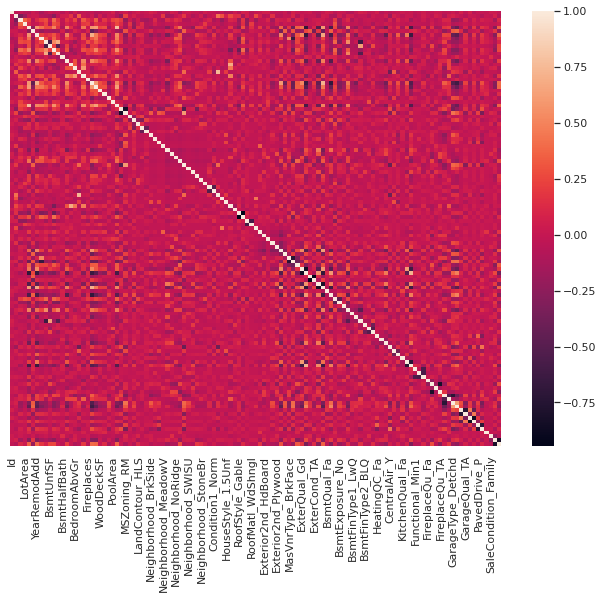

In [31]:
sns.heatmap(df2.corr(),yticklabels=False)

In [32]:
df2.shape

(583, 117)

We still end-up with too many features.. even after checking their contributions to the output 'SalePrice'

We have dropped these low contributing factors. We will come back to this and check if we adjusting the threshold helps or hurts the predictive power of the model

Lets drop columns that have low variance (lower than 0.15 which is an arbitray threshold)

In [33]:
index = 0
drop_list_3 = []
stdev = df2.describe().loc['std'].sort_values()
df2_col = df2.columns

#print(df2_col)
for i in stdev:
    if i < 0.15:
        drop_list_3.append(df2_col[index])
    index = index +1
print(drop_list_3)
print(len(drop_list_3))
        

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', '1stFlrSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']
23


We will remove these entries and we observe that the remaining features have a high variance

In [34]:
df2.drop(drop_list_3,axis =1,inplace = True)

<AxesSubplot:>

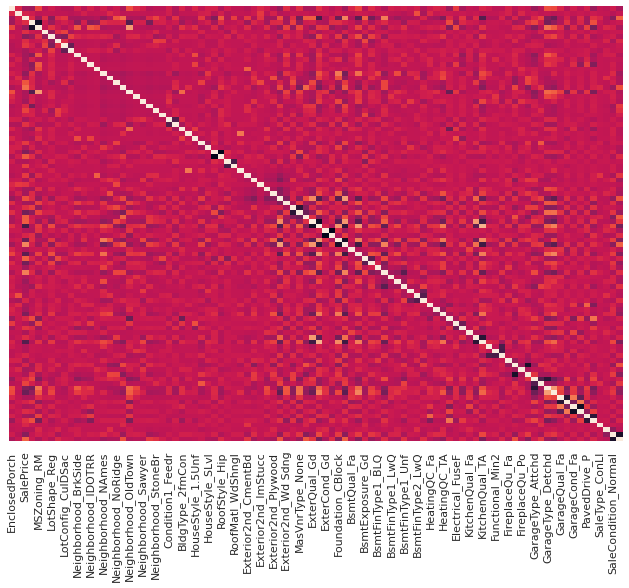

In [35]:
sns.heatmap(df2.corr(),yticklabels= False, cbar = False)

In [36]:
df2.shape

(583, 94)

checking for negetive correlations to drop features after one hot encoding

In [37]:
drop_list_4 = []
df2_corr = df2.corr()
for i in range(0,df2.shape[1]):
    for j in range(0,i):
        if ((df2_corr.iat[i,j] == -1) or (df2_corr.iat[i,j] < -0.9)):
            drop_list_4.append(df2.columns[i])
            
print(drop_list_4)
    


['RoofStyle_Hip', 'ExterCond_TA']


In [38]:
df2.drop(drop_list_4,axis =1, inplace =True)
df2.shape[1]

92

We get 92 features with which we will proceed with for our prediction. They are as follows

In [39]:
final_columns = df2.columns

print(final_columns)

Index(['EnclosedPorch', 'PoolArea', 'SalePrice', 'MSZoning_RL', 'MSZoning_RM',
       'LotShape_IR2', 'LotShape_Reg', 'LandContour_HLS', 'LotConfig_CulDSac',
       'LotConfig_Inside', 'Neighborhood_BrkSide', 'Neighborhood_Edwards',
       'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_NAmes',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Condition1_Feedr', 'Condition1_Norm', 'BldgType_2fmCon',
       'BldgType_Twnhs', 'HouseStyle_1.5Unf', 'HouseStyle_2Story',
       'HouseStyle_SLvl', 'RoofStyle_Gable', 'RoofMatl_CompShg',
       'RoofMatl_WdShngl', 'Exterior2nd_Brk Cmn', 'Exterior2nd_CmentBd',
       'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd',
       'Exterior2nd_Plywood', 'Exterior2nd_VinylSd', 'Exterior2nd_Wd Sdng',
       'MasVnrType_BrkFace', 'MasVnrT

## Feature Enigneering

Lets check the names and the data types of the columns that have null

In [40]:
def get_null_col(df_null_col):
    df_null_list =[]
    for i in df_null_col.columns:
        if(df_null_col[i].isnull().sum() > 0):
            df_null_list.append(i)
    print(df_null_list)
    return df_null_list
        

null_col = get_null_col(df1)


['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']


In [41]:
df1[null_col].isnull().sum()

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

LotFrontage: Linear feet of street connected to property, We will be filling this with interpolate(method = 'Linear') Later

<AxesSubplot:>

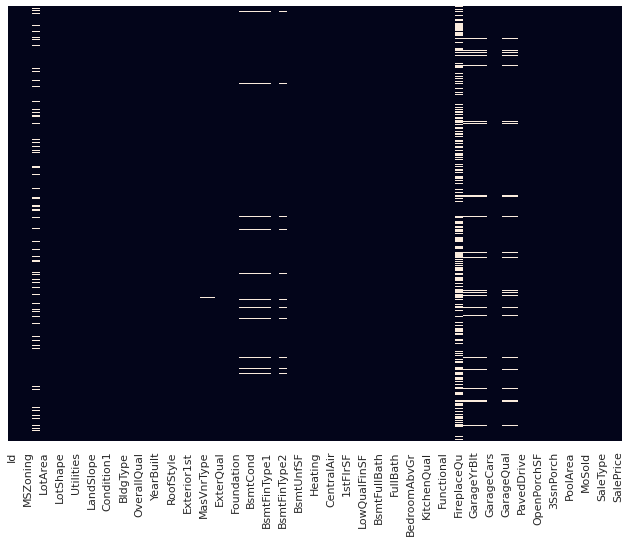

In [42]:
sns.heatmap(df1.isnull(),yticklabels= False, cbar = False)

We will be engineering the features FireplaceQu (Random Forest)

Now, to train the model for filling FireplaceQu using Random Forest Classifier, first we will remove the dummy columns for FireplaceQu

In [43]:
import re

fireplace_col = []
for i in df2.columns:
    if(re.search('^FireplaceQu*',i)):
        fireplace_col.append(i)
        print(i)
    

FireplaceQu_Fa
FireplaceQu_Gd
FireplaceQu_Po
FireplaceQu_TA


In [44]:
df3 = df2.drop(fireplace_col, axis =1)
df3.shape

(583, 88)

In [45]:
df3 = df3.drop('SalePrice', axis =1)

Add the FireplaceQu back to the dataframe and removing the null values, so that we can use the features to derive FireplaceQu

In [46]:
df3= df3.assign(FireplaceQu = df1.dropna()['FireplaceQu'])

In [47]:
df3.shape

(583, 88)

In [48]:
X_FireplaceQu = df3.drop('FireplaceQu',axis =1)
y_FireplaceQu = df3['FireplaceQu']

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
XFireplaceQu_train, XFireplaceQu_test, yFireplaceQu_train, yFireplaceQu_test = \
train_test_split(X_FireplaceQu, y_FireplaceQu, test_size=0.33, random_state=42)

In [51]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs = -1)
rfc.fit(XFireplaceQu_train,yFireplaceQu_train)

RandomForestClassifier(n_jobs=-1)

In [52]:
pred_rfc = rfc.predict(XFireplaceQu_test)
pred_rfc[:10]

array(['Gd', 'Gd', 'TA', 'Gd', 'Gd', 'Gd', 'Gd', 'Gd', 'TA', 'TA'],
      dtype=object)

In [53]:
XFireplaceQu_test.shape

(193, 87)

In [54]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(yFireplaceQu_test,pred_rfc))

print(classification_report(yFireplaceQu_test,pred_rfc))

[[ 0  0  8  0  1]
 [ 0  0  2  0  3]
 [ 0  0 92  0  7]
 [ 0  0  2  0  2]
 [ 1  0 38  0 37]]
              precision    recall  f1-score   support

          Ex       0.00      0.00      0.00         9
          Fa       0.00      0.00      0.00         5
          Gd       0.65      0.93      0.76        99
          Po       0.00      0.00      0.00         4
          TA       0.74      0.49      0.59        76

    accuracy                           0.67       193
   macro avg       0.28      0.28      0.27       193
weighted avg       0.62      0.67      0.62       193



Lets try to optimize this using Random Search CV

In [55]:
from sklearn.model_selection import RandomizedSearchCV

rfc_param_dist = {'n_estimators':[100,200,500,1000],
    'criterion': ['gini','entropy'],
    'max_depth':[3,5,10,None],
    'max_features':[5,7, 'auto'],
    'bootstrap': [True,False],
	'min_samples_leaf' : [1,3,5]
}

rand_search = RandomizedSearchCV(rfc, rfc_param_dist, n_jobs =-1,verbose = 2, cv = 5)

rand_search.fit(XFireplaceQu_train,yFireplaceQu_train)

rand_search.best_estimator_

rand_search.best_params_

In [56]:
rfc_opt = RandomForestClassifier(criterion='entropy', max_features=7, min_samples_leaf=3, n_estimators=500, n_jobs=-1)

In [57]:
rfc_opt.fit(XFireplaceQu_train,yFireplaceQu_train)
yFireplaceQu_pred = rfc_opt.predict(XFireplaceQu_test)
print(confusion_matrix(yFireplaceQu_test,yFireplaceQu_pred))
print(classification_report(yFireplaceQu_test,yFireplaceQu_pred))

[[ 0  0  9  0  0]
 [ 0  0  3  0  2]
 [ 0  0 93  0  6]
 [ 0  0  3  0  1]
 [ 0  0 39  0 37]]
              precision    recall  f1-score   support

          Ex       0.00      0.00      0.00         9
          Fa       0.00      0.00      0.00         5
          Gd       0.63      0.94      0.76        99
          Po       0.00      0.00      0.00         4
          TA       0.80      0.49      0.61        76

    accuracy                           0.67       193
   macro avg       0.29      0.29      0.27       193
weighted avg       0.64      0.67      0.63       193



<AxesSubplot:ylabel='Count'>

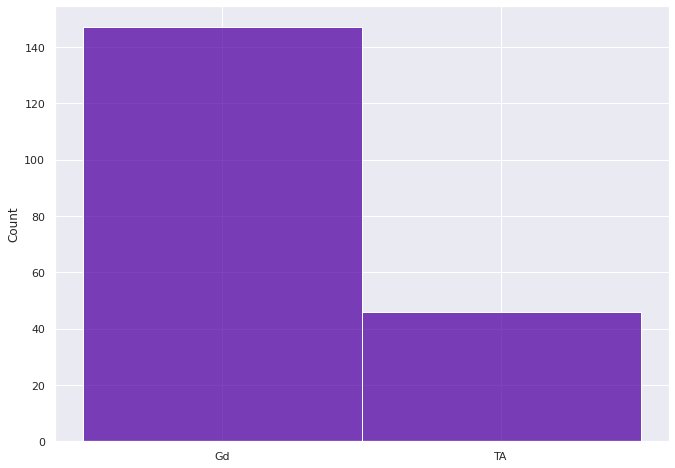

In [58]:
sns.histplot(yFireplaceQu_pred)

<AxesSubplot:ylabel='FireplaceQu'>

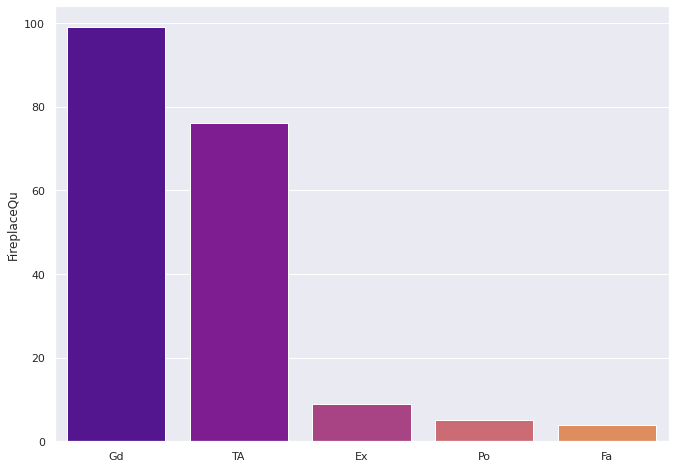

In [59]:
sns.barplot(y=yFireplaceQu_test.value_counts(), x= yFireplaceQu_test.unique())

We can see that the Gd and TA are the most predominant labels for in the FireplaceQu as a result we would be predicting all blanks between these classes

## Filling up the blank columns
Preparing the data frame  

In [60]:
df_final = df.drop(drop_col, axis =1)

In [61]:
df_final.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

In [62]:
df_final.isnull().sum().sum()

1558

Filling numerical columns with linear regression

In [63]:
df_final['LotFrontage'] = df_final['LotFrontage'].interpolate(method = 'linear')

In [64]:
df_final = fill_mean(df_final)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
filled data for Id as 730.5
filled data for MSSubClass as 56.897260273972606
filled data for LotFrontage as 70.20547945205479
filled data for LotArea as 10516.828082191782
filled data for OverallQual as 6.0993150684931505
filled data for OverallCond as 5.575342465753424
filled data for YearBuilt as 1971.267808219178
filled data for YearRemodAdd as 1984.8657534246574
filled data for MasVnrArea as 103

In [65]:
df_final.isnull().sum().sum()

1210

<AxesSubplot:>

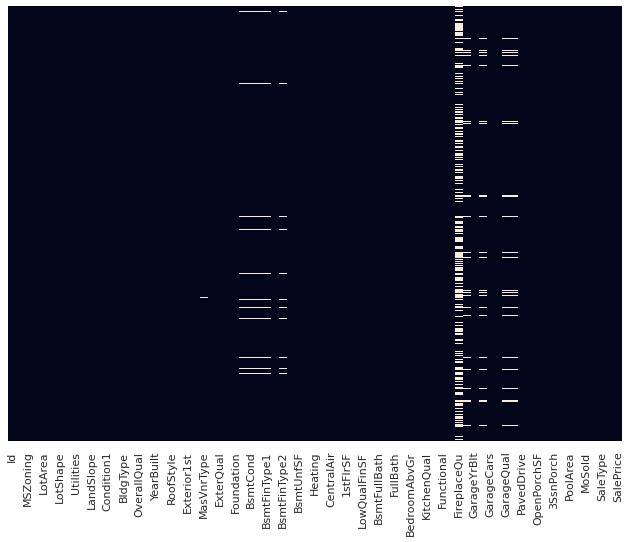

In [66]:
sns.heatmap(df_final.isnull(),yticklabels= False, cbar = False)

Filling remaining values except FireplaceQu, we will be imputing it. We will be dropping it, filling all other nan with ffill and then 

In [67]:
FireplaceQuList = df_final['FireplaceQu']
df_final = df_final.drop('FireplaceQu',axis =1)

In [68]:
df_final = fill_mode(df_final)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')
filled data for MSZoning as RL
filled data for Street as Pave
filled data for LotShape as Reg
filled data for LandContour as Lvl
filled data for Utilities as AllPub
filled data for LotConfig as Inside
filled data for LandSlope as Gtl
filled data for Neighborhood as NAmes
filled data for Condition1 as Norm
filled data for Condition2 as Norm
filled data for BldgType as 1Fam
filled data for HouseStyl

In [69]:
df_final.isnull().sum().sum()

0

In [70]:
for i in df_final.columns:
    if(df_final[i].isnull().sum() !=0):
        print(df_final[i])

In [71]:
df_final = df_final.assign(FireplaceQu = FireplaceQuList)

<AxesSubplot:>

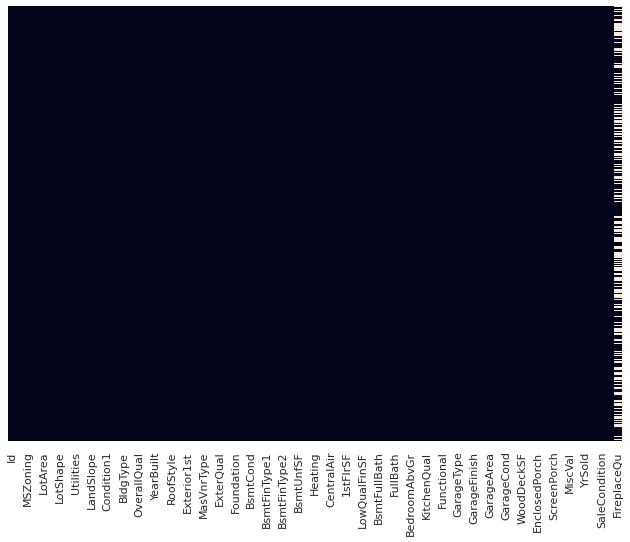

In [72]:
sns.heatmap(df_final.isnull(),yticklabels = False,cbar = False)

## Imputing FireplaceQu

In [73]:
def get_FireplaceQu(x):
    if(pd.isnull(x['FireplaceQu'])):
        # I had to take convert the serise into a pandas data frame and then take transpose of it to get columns for a single row.
        # Is there a better wy of doing this?
        x_test = pd.DataFrame(x).T.drop('FireplaceQu',axis =1)
        #print(x_test)
        return rfc_opt.predict(x_test)[0]
    else:
        return x['FireplaceQu']

taking 1-hot encoding and deleting dummies for FireplaceQu then reassign the original column FireplaceQu

In [74]:
df_final1 = pd.get_dummies(df_final, drop_first = True)[final_columns]

In [75]:
df_final1.drop(fireplace_col,axis =1,inplace = True)

In [76]:
df_final1 = df_final1.assign(FireplaceQu = FireplaceQuList)

In [77]:
FireplaceQu_pred = df_final1.drop('SalePrice',axis =1).apply(get_FireplaceQu, axis =1)
FireplaceQu_pred.isnull().sum()

0

<AxesSubplot:ylabel='Count'>

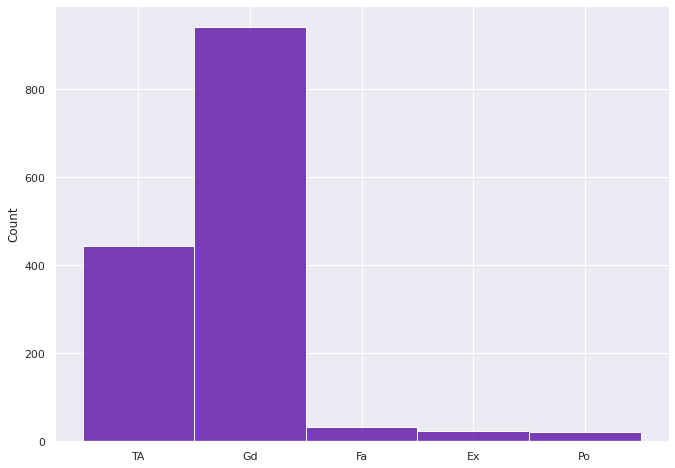

In [78]:
sns.histplot(FireplaceQu_pred)

Merging predicted column with the original dataframe

In [79]:
df_final2 = df_final.assign(FireplaceQu = FireplaceQu_pred)

Checking the sanity of data frame

In [80]:
df_final2.FireplaceQu.unique()

array(['TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [81]:
df_final2.shape

(1460, 77)

<AxesSubplot:>

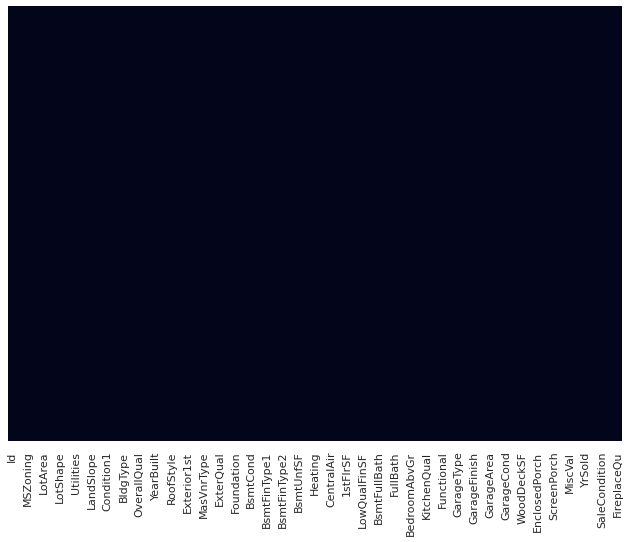

In [82]:
sns.heatmap(df_final2.isnull(),yticklabels= False,cbar =False)

In [83]:
for i in (df_final2.columns):
    print(i," : ",df_final2[i].isnull().sum())

Id  :  0
MSSubClass  :  0
MSZoning  :  0
LotFrontage  :  0
LotArea  :  0
Street  :  0
LotShape  :  0
LandContour  :  0
Utilities  :  0
LotConfig  :  0
LandSlope  :  0
Neighborhood  :  0
Condition1  :  0
Condition2  :  0
BldgType  :  0
HouseStyle  :  0
OverallQual  :  0
OverallCond  :  0
YearBuilt  :  0
YearRemodAdd  :  0
RoofStyle  :  0
RoofMatl  :  0
Exterior1st  :  0
Exterior2nd  :  0
MasVnrType  :  0
MasVnrArea  :  0
ExterQual  :  0
ExterCond  :  0
Foundation  :  0
BsmtQual  :  0
BsmtCond  :  0
BsmtExposure  :  0
BsmtFinType1  :  0
BsmtFinSF1  :  0
BsmtFinType2  :  0
BsmtFinSF2  :  0
BsmtUnfSF  :  0
TotalBsmtSF  :  0
Heating  :  0
HeatingQC  :  0
CentralAir  :  0
Electrical  :  0
1stFlrSF  :  0
2ndFlrSF  :  0
LowQualFinSF  :  0
GrLivArea  :  0
BsmtFullBath  :  0
BsmtHalfBath  :  0
FullBath  :  0
HalfBath  :  0
BedroomAbvGr  :  0
KitchenAbvGr  :  0
KitchenQual  :  0
TotRmsAbvGrd  :  0
Functional  :  0
Fireplaces  :  0
GarageType  :  0
GarageYrBlt  :  0
GarageFinish  :  0
GarageCars  

In [84]:
df_final2 = pd.get_dummies(df_final2, drop_first = True)[final_columns]

df_final2.shape

(1460, 92)

In [85]:
X = df_final2.drop('SalePrice',axis =1)
y = df_final2['SalePrice']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [87]:
import xgboost

xgb_Reg = xgboost.XGBRegressor(base_score = 0.226, objective = 'reg:squarederror', eval_metric = 'rmse',seed = 20)

In [88]:
xgb_Reg.fit(X_train,y_train)

XGBRegressor(base_score=0.226, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=20,
             reg_alpha=0, reg_lambda=1, ...)

In [89]:
y_pred= xgb_Reg.predict(X_test)

In [90]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,y_pred)
np.sqrt(mse)

44381.08034813127

<AxesSubplot:xlabel='SalePrice'>

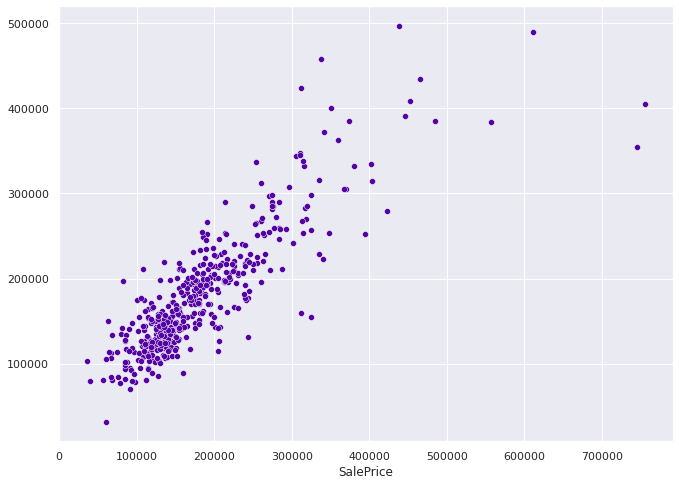

In [91]:
sns.scatterplot(x = y_test, y = y_pred)

In [92]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test,y_pred)
np.sqrt(mse)

44381.08034813127

### Converting the random search to Markdown so that it does not run and we pick it up from the pickle file

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

random_search=RandomizedSearchCV(xgb_Reg,params,scoring='neg_mean_squared_error',n_iter=10,n_jobs=-1,verbose=1)

random_search.fit(X_train,y_train)

random_search.best_params_

In [93]:
XGBReg_Opt = xgboost.XGBRegressor(base_score = 0.226, objective = 'reg:squaredlogerror', eval_metric = 'rmse',subsample= 0.6,n_estimators= 1000, max_depth= 5, learning_rate= 0.01,
                                  colsample_bytree= 0.9,colsample_bylevel= 0.6)

In [94]:
XGBReg_Opt.fit(X_train,y_train)

XGBRegressor(base_score=0.226, booster='gbtree', callbacks=None,
             colsample_bylevel=0.6, colsample_bynode=1, colsample_bytree=0.9,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, objective='reg:squaredlogerror',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [95]:
y_pred = XGBReg_Opt.predict(X_test)

<AxesSubplot:xlabel='SalePrice'>

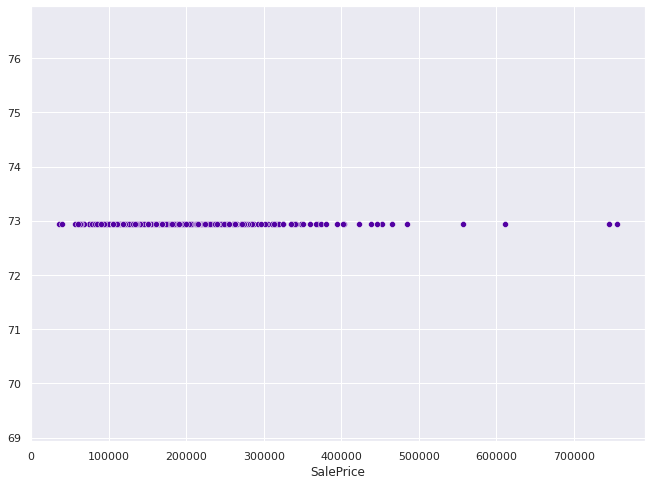

In [96]:
sns.scatterplot(x = y_test, y = y_pred)

In [97]:
mse = mean_squared_error(y_test,y_pred)
np.sqrt(mse)

199888.10104421593

## Now to process data for the train set

In [98]:
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [99]:
df_test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [100]:
id_list = df_test['Id']

In [101]:
df_test= df_test.drop(drop_col, axis =1)

In [102]:
df_test['LotFrontage'] = df_test['LotFrontage'].interpolate(method = 'linear')

In [103]:
df_test = fill_mean(df_test)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')
filled data for Id as 2190.0
filled data for MSSubClass as 57.37834132967786
filled data for LotFrontage as 68.88176833447567
filled data for LotArea as 9819.161069225496
filled data for OverallQual as 6.078821110349555
filled data for OverallCond as 5.5538039753255655
filled data for YearBuilt as 1971.357779300891
filled data for YearRemodAdd as 1983.6627827278958
filled data for MasVnrArea as 100.7091412742382

In [104]:
df_test.isnull().sum().sum()

1285

In [105]:
FireplaceQuList = df_test['FireplaceQu']
df_test = df_test.drop('FireplaceQu',axis =1)

In [106]:
df_test = fill_mode(df_test)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')
filled data for MSZoning as RL
filled data for Street as Pave
filled data for LotShape as Reg
filled data for LandContour as Lvl
filled data for Utilities as AllPub
filled data for LotConfig as Inside
filled data for LandSlope as Gtl
filled data for Neighborhood as NAmes
filled data for Condition1 as Norm
filled data for Condition2 as Norm
filled data for BldgType as 1Fam
filled data for HouseStyl

In [107]:
df_test1 = pd.get_dummies(df_test)

In [108]:
df_test1 = df_test1[final_columns.drop(['SalePrice', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA'])]

In [109]:
df_test1 = df_test1.assign(FireplaceQu = FireplaceQuList)

In [110]:
FireplaceQu_pred = df_test1.apply(get_FireplaceQu, axis =1)

In [111]:
df_test = df_test1.assign(FireplaceQu = FireplaceQu_pred)

In [112]:
df_test = pd.get_dummies(df_test)

In [113]:
df_test = df_test[final_columns.drop('SalePrice')]

<AxesSubplot:>

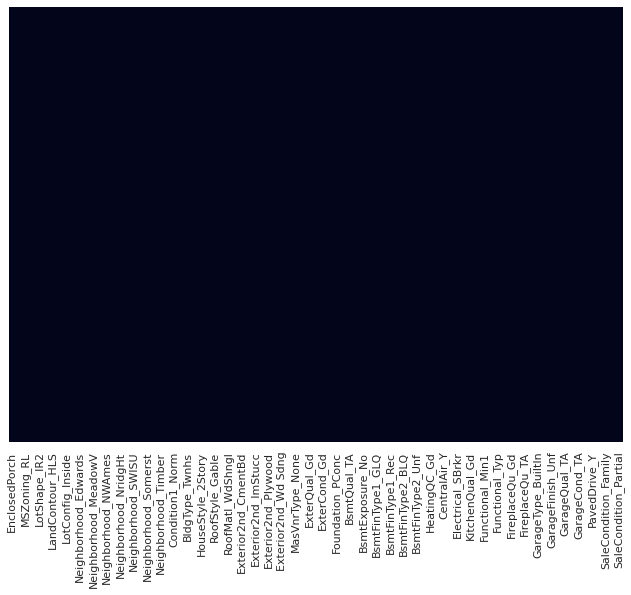

In [114]:
sns.heatmap(df_test.isnull(),yticklabels=False,cbar = False)

In [115]:
df_test.shape

(1459, 91)

## Predicting the test outcome

In [116]:
y_test_Pred = XGBReg_Opt.predict(df_test)

In [117]:
type(y_test_Pred)

numpy.ndarray

In [118]:
frame = { 'Id': id_list, 'SalePrice': y_test_Pred }

In [119]:
final_df = pd.DataFrame(frame)

In [120]:
final_df.head()

,Id,SalePrice
0,1461,72.942032
1,1462,72.942032
2,1463,72.942032
3,1464,72.942032
4,1465,72.942032


In [121]:
final_df.to_csv('Output1.csv', index=False)